In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import rc as pltrc
from matplotlib.gridspec import GridSpec

def flat_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def convert_to_year(range_time, low, high):
    delta_time = high-low
    full_date = low + range_time*delta_time
    return full_date.year

In [2]:
roster = pd.read_csv('../final/roster.csv')
roster.head()

,last_name,first_name,middle_initial,gender,race,birthyear,age,status,appointment_date,position_no,...,star7,star8,star9,star10,star11,sworn,unit_id,unit_detail,star,uid
0,HANSEN,GRACIBEL,NaN,F,WHITE HISPANIC,1973.0,44.0,Y,2004-10-25,9161,...,NaN,NaN,NaN,NaN,NaN,Y,13.0,NaN,5512.0,2162b5ba-fd29-4474-8c70-455fb642bb1f
1,AARON,JEFFERY,M,M,WHITE,1971.0,46.0,Y,2005-09-26,9171,...,NaN,NaN,NaN,NaN,NaN,Y,21.0,NaN,1424.0,c251a31d-030f-40a0-900e-4dc7f6f86d51
2,AARON,KARINA,NaN,F,WHITE HISPANIC,1980.0,37.0,Y,2005-09-26,9165,...,NaN,NaN,NaN,NaN,NaN,Y,194.0,NaN,20373.0,f6aedb8d-3c01-4838-a3a9-b50cee054a1b
3,ABATE,DANIEL,P,M,WHITE,1942.0,75.0,N,1970-06-15,9161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549d5ddc-9e5a-4b12-9ab0-022c6dbca249
4,ABBATE,ANTHONY,G,M,WHITE,1968.0,48.0,N,1994-12-05,9161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cfae6371-0e9a-4382-b35c-19c52f2dfb4a


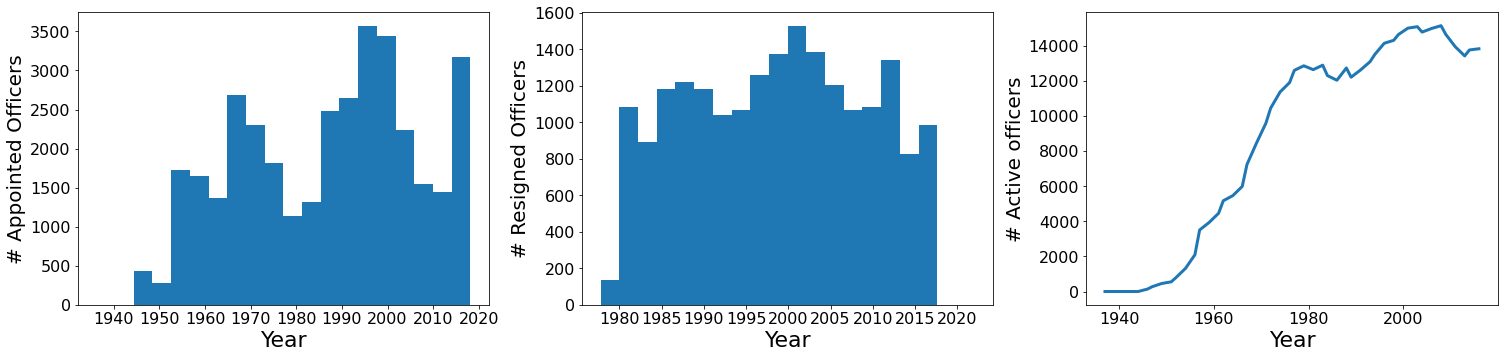

In [10]:
appointment_dates = pd.to_datetime(roster['appointment_date'].values)
resignation_dates = pd.to_datetime(roster['resignation_date'].values)

pltrc('xtick', labelsize= 16) 
pltrc('ytick', labelsize= 16) 

plt.figure(figsize = (21,5))


plt.subplot(131)
plt.hist(appointment_dates, bins = 20)
plt.xlabel('Year', fontsize = 22)
plt.ylabel('# Appointed Officers', fontsize = 20)

plt.subplot(132)
plt.hist(resignation_dates, bins=20)
plt.xlabel('Year', fontsize = 22)
plt.ylabel('# Resigned Officers', fontsize = 20)
    
plt.subplot(133)

first_appointment_date, last_appointment_date = min(appointment_dates), max(appointment_dates)
delta_time = last_appointment_date - first_appointment_date # largest delta time
actives = (pd.to_datetime(roster['appointment_date'].values) - first_appointment_date)/delta_time
inactives = (pd.to_datetime(roster['resignation_date'].values) - first_appointment_date)/delta_time
inactives = np.nan_to_num(inactives, nan=1)
how_many_active = []
range_time = np.linspace(0,1,50)
years = [convert_to_year(r, first_appointment_date, last_appointment_date) for r in range_time]
for r in range_time:
    how_many_active.append(np.sum((actives<r)*(inactives>r)))

plt.plot(years[1:-1], how_many_active[1:-1], lw = 3)
plt.ylabel('# Active officers', fontsize = 20)
plt.xlabel('Year', fontsize = 22)

plt.tight_layout()
# plt.savefig('../doc/figs/history.pdf', dpi=1000, bbox_inches = 'tight')
plt.show()

In [11]:
roster_by = roster.drop(roster[roster['birthyear'] > 1998].index, inplace = False)
yearz = roster_by['birthyear'].sort_values().dropna()
min_year = min(yearz.values) 
max_year = max(yearz.values)
width_year_windows = 5

binned = np.bincount((yearz - min_year)//width_year_windows)
bins = np.arange(min_year, max_year, width_year_windows, dtype = int)
bins_text = [str(bins[t])+'-'+str(bins[t]+width_year_windows-1)[-2:] for t in range(len(bins))]

act_roster = roster_by.fillna({'resignation_date':'2019-01-01'})
act_roster.drop(act_roster[act_roster['resignation_date'] < '2019-01-01'].index, inplace = True)
act_yearz = act_roster['birthyear'].sort_values().dropna()
act_binned = np.bincount((act_yearz - min_year)//width_year_windows)

In [12]:
gender_count, race_count, birthyear_count, status_count = roster['gender'].value_counts(), roster['race'].value_counts(), roster['birthyear'].sort_values().value_counts(), roster['status'].value_counts()
gender_count, race_count

(M    28316
 F     7122
 X       12
 Name: gender, dtype: int64,
 WHITE                      21047
 BLACK                       8599
 WHITE HISPANIC              4811
 ASIAN/PACIFIC ISLANDER       582
 AMER IND/ALASKAN NATIVE       67
 BLACK HISPANIC                 9
 Name: race, dtype: int64)

In [13]:
act_gender_count, act_race_count, act_birthyear_count, act_status_count = act_roster['gender'].value_counts(), act_roster['race'].value_counts(), act_roster['birthyear'].sort_values().value_counts(), act_roster['status'].value_counts()
act_gender_count, act_race_count

(M    11118
 F     4452
 X       12
 Name: gender, dtype: int64,
 WHITE                      7241
 BLACK                      3895
 WHITE HISPANIC             3596
 ASIAN/PACIFIC ISLANDER      467
 AMER IND/ALASKAN NATIVE      40
 BLACK HISPANIC                9
 Name: race, dtype: int64)

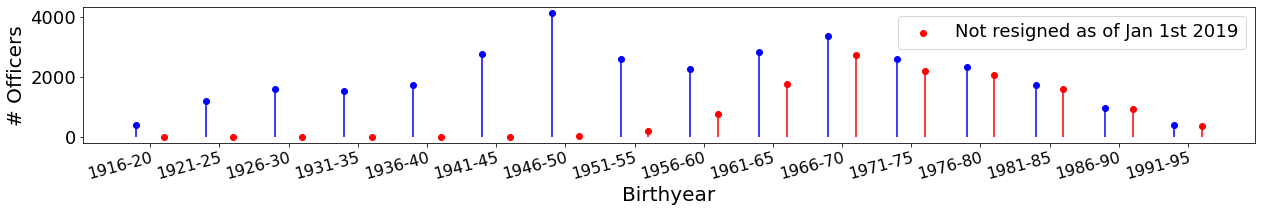

In [33]:
plt.figure(figsize = (21,2.5))
ax = plt.subplot(111)

plt.scatter(bins-1, binned, color = 'blue')
plt.vlines(x = bins-1, ymin = np.zeros(len(bins)), ymax = binned, color = 'blue')

plt.scatter(bins+1, act_binned, color = 'r', label = 'Not resigned as of Jan 1st 2019')
plt.vlines(x = bins+1, ymin = np.zeros(len(bins)), ymax = act_binned, color = 'r')

plt.xticks(bins, bins_text)
plt.setp(ax.xaxis.get_majorticklabels(),rotation=15, ha="right", rotation_mode="anchor") 
plt.ylabel('# Officers', fontsize = 20)
plt.xlabel('Birthyear', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 18, loc = '')
plt.savefig('../doc/figs/history_by.pdf', dpi=1000, bbox_inches = 'tight')
plt.show()